# Biharmonic Equation in 2D Cartesian Coordinates

**Settings**

The Biharmonic function in 2d cartesian coordinates is:
\begin{equation}
\nabla^4 \phi = \nabla^2 (\nabla^2 \phi) = \frac{\partial^4 \phi}{\partial x^4} + 2 \frac{\partial^4 \phi}{\partial x^2 \partial y^2} + \frac{\partial^4 \phi}{\partial y^4} = 0
\end{equation}

With the boundary conditions:

\begin{equation}
\frac{\partial \phi}{\partial x} = \frac{\partial \phi}{\partial y} = 0, \quad & \text{when } y = 0 \text{ and } y = 1  \\
\frac{\partial \phi}{\partial x} = 0, \frac{\partial \phi}{\partial y} = f(y), \quad & \text{when } x = 0 \\
\frac{\partial \phi}{\partial x} = 0, \frac{\partial \phi}{\partial y} = g(y), \quad & \text{when } x = 1 
\end{equation}

where assume 
\begin{equation}
f(y) = g(y) = 
\begin{cases}
C * ((\lambda /2)^2 - (y-1/2)^2) \qquad & 1/2 - \lambda/2 < y < 1/2 + \lambda/2\\
0 \qquad &  \text{elsewhere}
\end{cases}
 
\end{equation}

### Central Difference Discretization

In this script:

1. A 2D grid is created using `Nx` and `Ny` to specify the number of points in each direction.
2. A mapping function `idx(i, j)` is defined to convert 2D grid coordinates to a single index for a 1D array representation.
3. The matrix `A` is constructed using a finite difference approximation suitable for the biharmonic operator, considering the appropriate coefficients for the fourth derivatives.
4. Neumann boundary conditions are applied to `A` by setting the first derivative to zero at the grid points adjacent to the boundaries using a first-order finite difference approximation.
5. The matrix `A` is converted to Compressed Sparse Row (CSR) format for efficient storage and solving.
6. The linear system is solved using `spsolve`, and the solution `phi` is reshaped back into a 2D array.
7. The solution is plotted using `matplotlib` to visualize the function ($\phi$).



In [62]:
import numpy as np
from scipy.sparse import lil_matrix
from scipy.sparse.linalg import spsolve

In [63]:
# Define the grid
Nx, Ny = 10, 10  # number of grid points in x and y direction
x = np.linspace(0, 1, Nx+1)
y = np.linspace(0, 1, Ny+1)
dx, dy = x[1] - x[0], y[1] - y[0]

# Count the number of rows in the matrix A
count_row = 0


In [64]:
# Initialize the discretization matrix and right-hand side vector
A = np.zeros(((Nx+1) * (Ny+1) + 20, (Nx+1) * (Ny+1))) # since we have more rows than columns, we manually set the shape of the matrix
b = np.zeros((Nx+1) * (Ny+1) + 20) # the right-hand side vector, len(b) = the number of rows in A
# U = [U00, U10 ... UN0, U10, U01, U11 ... UN1 ... U0N, U1N ... UNN] with length (N+1)^2


In [65]:
# Define function f(y) and g(y)
def f(z, C = 30, lamb = 2/10):
    # Step function
    if 1/2 - lamb/2 < z < 1/2 + lamb/2:
        return C * ((lamb/2)**2 - (z-1/2)**2)
    else:
        return 0

def g(z):
    return f(z)  # Since g(y) = f(y) in the problem definition

In [66]:
# internal points
# for i in range(2, Nx - 1):  # Start from 2 and end at Nx-2 to avoid out-of-bounds
# for j in range(2, Ny - 1):  # Start from 2 and end at Ny-2 for the same reason
# Ui-2,j - 8Ui-1,j + 20Ui,j - 8Ui+1,j + Ui+2,j + Ui,j-2 - 8Ui,j-1 - 8Ui,j+1 + Ui,j+2 + 2Ui-1,j-1 + 2Ui-1,j+1 + 2Ui+1,j-1 + 2Ui+1,j+1 = 0
# rearranging the equation in the same order as the U vector
# Ui,j-2 + 2Ui-1,j-1 - 8Ui,j-1 + 2Ui+1,j-1 + Ui-2,j - 8Ui-1,j + 20Ui,j - 8Ui+1,j + Ui+2,j + 2Ui-1,j+1 - 8Ui,j+1 + 2Ui+1,j+1 + Ui,j+2 = 0

# boundary points
# if j == 0 or j == Ny:
# second-order forward/backward finite difference approximation for the first derivative
# -3/2 Ui,j +2 Ui+1,j -1/2 Ui+2,j = 0
# -3/2 Ui,0 +2 Ui,1 -1/2 Ui,2  = 0
# 1/2 Ui,Ny-2 -2 Ui,Ny-1 +3/2 Ui,Ny= 0

# if i == 0 or i == Nx:
# second-order forward/backward finite difference approximation for the first derivative
# -3/2 U0,j +2 U1,j -1/2 U2,j = 0
# 1/2 UNx-2,j -2 UNx-1,j +3/2 UNx,j  = 0
# (-3/2 U0,j +2 U0,j+1 -1/2 U0,j+2)/dy = f(j*dy)
# (-3/2 UNx,j +2 UNx,j+1 -1/2 UNx,j+2)/dy = g(j*dy)

# if i == 1 and j > 1 and j < Ny-1:
# U5,j - 4U4,j + 2U3,j +4U2,j + 3U1,j + U1,j-2 - 2U1,j-1 - 2U1,j+1 + U1,j+2 + 2U3,j-1 - 4U2,j-1 + 2U3,j+1 - 4U2,j+1 = 0
# rearranging the equation in the same order as the U vector
# U1,j-2 - 2U1,j-1 - 4U2,j-1 + 2U3,j-1 + 3U1,j +4U2,j + 2U3,j - 4U4,j + U5,j - 2U1,j+1 - 4U2,j+1 + 2U3,j+1 + U1,j+2 = 0

# if j == 1 and i > 1 and i < Nx-1:
# Ui,5 - 4Ui,4 + 2Ui,3 + 4Ui,2 + 3Ui,1 + Ui-2,1 - 2Ui-1,1 - 2Ui+1,1 + Ui+2,1 + 2Ui-1,3 - 4Ui-1,2 + 2Ui+1,3 - 4Ui+1,2 = 0
# rearranging the equation in the same order as the U vector
# Ui-2,1 - 2Ui-1,1 + 3Ui,1 - 2Ui+1,1 + Ui+2,1 - 4Ui-1,2 + 4Ui,2 - 4Ui+1,2 + 2Ui-1,3 + 2Ui,3 + 2Ui+1,3 - 4Ui,4 + Ui,5 = 0

# if i == 1 and j == 1:
# U5,1 - 4U4,1 + 7U3,1 - 6U2,1 + U1,1 + U1,5 - 4U1,4 + 7U1,3 - 6U1,2 + U3,3 - 2U2,3 - 2U3,2 + 4U2,2 = 0
# rearranging the equation in the same order as the U vector
# U1,1 - 6U2,1 + 7U3,1 - 4U4,1 + U5,1 - 6U1,2 + 4U2,2 - 2U3,2 + 7U1,3 - 2U2,3 + U3,3 - 4U1,4 + U1,5 = 0

# if i == 1 and j == Ny-1:


# if i == Nx-1 and j > 1 and j < Ny-1:


# if j == Ny-1 and i > 1 and i < Nx-1:


# if i == Nx-1 and j == 1:


# if j == Ny-1 and i == Nx-1:


In [67]:
# Function to map 2D grid coordinates to 1D vector index
def idx(i, j):
    return i * (Ny+1) + j


In [68]:
# Fill the matrix A and vector b for the internal points
for row in range((Nx-3)*(Ny-3)):
    # Second-order finite difference approximation for the biharmonic operator
    for i in range(2, Nx - 1):  # Start from 2 and end at Nx-2 to avoid out-of-bounds
        for j in range(2, Ny - 1):  # Start from 2 and end at Ny-2 for the same reason
            index = idx(i, j)
            # Ui,j-2 + 2Ui-1,j-1 - 8Ui,j-1 + 2Ui+1,j-1 + Ui-2,j - 8Ui-1,j + 20Ui,j - 8Ui+1,j + Ui+2,j + 2Ui-1,j+1 - 8Ui,j+1 + 2Ui+1,j+1 + Ui,j+2 = 0
            A[count_row, idx(i, j-2)] = 1
            A[count_row, idx(i-1, j-1)] = 2
            A[count_row, idx(i, j-1)] = -8
            A[count_row, idx(i+1, j-1)] = 2
            A[count_row, idx(i-2, j)] = 1
            A[count_row, idx(i-1, j)] = -8
            A[count_row, idx(i, j)] = 20
            A[count_row, idx(i+1, j)] = -8
            A[count_row, idx(i+2, j)] = 1
            A[count_row, idx(i-1, j+1)] = 2
            A[count_row, idx(i, j+1)] = -8
            A[count_row, idx(i+1, j+1)] = 2
            A[count_row, idx(i, j+2)] = 1
            
    b[count_row] = 0
    count_row += 1
    
print(f'count_row: {count_row}')

count_row: 49


In [69]:
# boundary points
# y = 0:
# -3/2 Ui,0 +2 Ui+1,0 -1/2 Ui+2,0 = 0
for i in range(Nx-1):
    
    A[count_row, idx(i+2, 0)] = -1/2
    A[count_row, idx(i+1, 0)] = 2
    A[count_row, idx(i, 0)] = -3/2
        
    b[count_row] = 0
    count_row += 1

print(f'count_row: {count_row}')

count_row: 58


In [70]:
# boundary points
# y = 0: 
# -3/2 Ui,0 +2 Ui,1 -1/2 Ui,2  = 0
for i in range(Nx+1):
    A[count_row, idx(i, 2)] = -1/2
    A[count_row, idx(i, 1)] = 2
    A[count_row, idx(i, 0)] = -3/2
        
    b[count_row] = 0
    count_row += 1
    
print(f'count_row: {count_row}')

count_row: 69


In [71]:
# boundary points
# y = 1: 
# -3/2 Ui,Ny +2 Ui+1,Ny -1/2 Ui+2,Ny = 0
for i in range(Nx-1):
    A[count_row, idx(i+2, Ny)] = -1/2
    A[count_row, idx(i+1, Ny)] = 2
    A[count_row, idx(i, Ny)] = -3/2
        
    b[count_row] = 0
    count_row += 1

print(f'count_row: {count_row}')

count_row: 78


In [72]:
# boundary points
# y = 1: 
# 1/2 Ui,Ny-2 -2 Ui,Ny-1 +3/2 Ui,Ny= 0
for i in range(Nx+1):
    A[count_row, idx(i, Ny-2)] = 1/2
    A[count_row, idx(i, Ny-1)] = -2
    A[count_row, idx(i, Ny)] = 3/2
        
    b[count_row] = 0
    count_row += 1

print(f'count_row: {count_row}')

count_row: 89


In [73]:
# boundary points
# x = 0: 
# -3/2 U0,j +2 U1,j -1/2 U2,j = 0
for j in range(Ny+1):
    A[count_row, idx(2, j)] = -1/2
    A[count_row, idx(1, j)] = 2
    A[count_row, idx(0, j)] = -3/2
        
    b[count_row] = 0
    count_row += 1
    
print(f'count_row: {count_row}')

count_row: 100


In [74]:
# boundary points
# x = 1: 
# 1/2 UNx-2,j -2 UNx-1,j +3/2 UNx,j  = 0
for j in range(Ny+1):
    A[count_row, idx(Nx-2, j)] = 1/2
    A[count_row, idx(Nx-1, j)] = -2
    A[count_row, idx(Nx, j)] = 3/2
        
    b[count_row] = 0
    count_row += 1

print(f'count_row: {count_row}')

count_row: 111


In [75]:
# boundary points
# x = 0: 
# (-3/2 U0,j +2 U0,j+1 -1/2 U0,j+2)/dy = f(j*dy)
for j in range(Ny-1):
    A[count_row, idx(0, j+2)] = (-1/2) /dy
    A[count_row, idx(0, j+1)] = 2/dy
    A[count_row, idx(0, j)] = (-3/2)/dy
    
    b[count_row] = f(j*dy)
    count_row += 1

print(f'count_row: {count_row}')

count_row: 120


In [76]:
# boundary points
# x = 1: 
# (-3/2 UNx,j +2 UNx,j+1 -1/2 UNx,j+2)/dy = g(j*dy)
for j in range(Ny-1):
    A[count_row, idx(Nx, j+2)] = (-1/2) /dy
    A[count_row, idx(Nx, j+1)] = 2/dy
    A[count_row, idx(Nx, j)] = (-3/2)/dy

    b[count_row] = g(j*dy)
    count_row += 1
    
print(f'count_row: {count_row}')

count_row: 129


In [77]:
# show the matrix A in detail
A

array([[0., 0., 1., ..., 1., 0., 0.],
       [0., 0., 1., ..., 1., 0., 0.],
       [0., 0., 1., ..., 1., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [78]:
# Solve the linear system
U, residuals, rank, s = np.linalg.lstsq(A, b, rcond=None)


In [79]:
# Convert the solution to a 2D grid
phi = U.reshape((Nx+1, Ny+1))

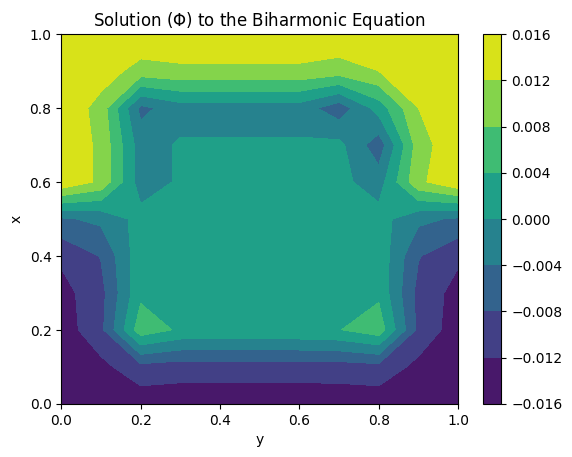

In [80]:
# Plot the solution
import matplotlib.pyplot as plt

X, Y = np.meshgrid(x, y)
plt.contourf(Y, X, phi, cmap='viridis')
plt.colorbar()
plt.title('Solution ($\Phi$) to the Biharmonic Equation')
plt.xlabel('y')
plt.ylabel('x')
plt.show()


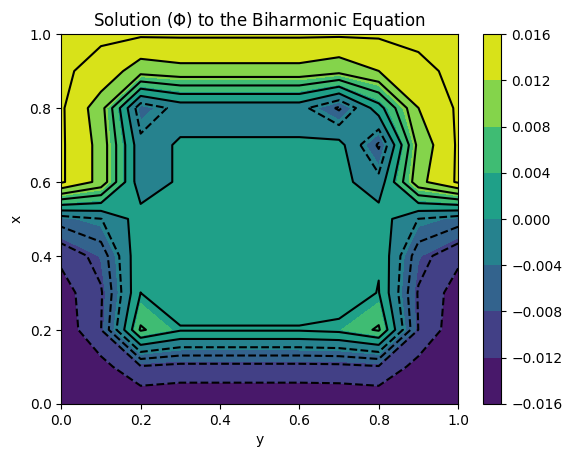

In [81]:
import numpy as np
import matplotlib.pyplot as plt

# Assuming x, y, and phi are defined previously in your code:
X, Y = np.meshgrid(x, y)

plt.contourf(Y, X, phi, cmap='viridis')  # Filled contour plot
plt.colorbar()  # Color bar for reference

# Add contour lines over the filled contour plot:
# Here, you can specify the number of levels or the specific levels you want to plot
# For example, levels=10 will create 10 levels (auto-chosen), or you can pass a list
# of values to specify the exact contour levels you want to see.
plt.contour(Y, X, phi, colors='k', levels=10)  # 'k' stands for black color lines

plt.title('Solution ($\Phi$) to the Biharmonic Equation')
plt.xlabel('y')
plt.ylabel('x')
plt.show()
